In [2]:
import os
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import random
import math
import tensorflow as tf
import sys
from scipy import stats

from PIL import Image
from matplotlib import pyplot
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, SeparableConv2D, BatchNormalization, MaxPooling2D, Dense, Dropout, Flatten, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

In [1]:
def unzip_samples(file = "data.zip", overwrite = False):
    if not os.path.exists(os.path.splitext(file)[0]) or overwrite:
        print("Unzip data set...")
        with zipfile.ZipFile(file, 'r') as zip_ref:
            zip_ref.extractall(".")

def generate_datasets(zip_data_path = "data.zip", train_set_path = "train_set", train_set_size = 200, test_set_path = "test_set", test_set_size = 50, validation_set_path = "validation_set", validation_set_size = 50, channels = [], crop_area = (0, 0, 32, 32), size = (32, 32), unzip = True):
    if unzip:
        unzip_samples(zip_data_path)
    generate_tensors(train_set_path, sample_start = 1, sample_end = train_set_size, channels = channels, crop_area = crop_area, size = size)
    generate_tensors(test_set_path, sample_start = 1, sample_end = test_set_size, channels = channels, crop_area = crop_area, size = size)
    generate_tensors(validation_set_path, sample_start = test_set_size + 1, sample_end = test_set_size + validation_set_size, channels = channels, crop_area = crop_area, size = size)

def sample_path(class_name, sample, channel, size):
    png_path = "dataset" + str(size[1]) + "x" + str(size[0]) + "/" + class_name + "/CH" + str(channel) + "/sample" + str(sample) + ".png"
    return png_path

def show_sample(class_name, sample, crop_area = (0, 0, 32, 32), size = (32, 32)):
    print("Sample = {}, class = {}".format(sample, class_name))
    fig, ax = plt.subplots(1, 7)
    fig.set_figwidth(20)
    fig.set_figheight(10)
    for i in range(7):
        im = Image.open(sample_path(class_name = class_name, sample = sample, channel = i+1, size = size), "r").crop(crop_area).resize(size)
        ax[i].set_title("Ch {}".format(i+1))
        ax[i].imshow(im)
    fig.show()

def show_grid(sample, channels = 4, crop_area = (0, 0, 32, 32), size = (32, 32)):
    print("Grid (sample = {}, channels = {})".format(sample, channels))
    fig, ax = plt.subplots(10, 10)
    fig.set_figwidth(20)
    fig.set_figheight(24)
    matrix = np.zeros((size[1], size[0], channels), dtype="uint8")
    for row in range(10):
        for col in range(10):
            if (row == 0 and col == 0) or (row == 0 and col == 9) or (row == 9 and col == 0) or (row == 9 and col == 9):
                    continue
            class_name = "P_x" + str(row + 1) + "_y" + str(col + 1)
            for ch in range(channels):
                matrix[:, :, ch] = np.array(Image.open(sample_path(class_name = class_name, sample = sample, channel = ch + 1, size = size), "r").crop(crop_area).resize(size))
            ax[row, col].set_title(class_name)
            ax[row, col].imshow(matrix)
    plt.show()

def generate_sample_tensor(class_name = "A11", sample = 1, channels = [], crop_area = (0, 0, 32, 32), size = (32, 32)):
    tensor = np.zeros((size[1], size[0], len(channels)), dtype="uint8")
    for ch in range (len(channels)):
        img = Image.open(sample_path(class_name = class_name, sample = sample, channel = channels[ch], size = size), "r")
        img = img.crop(crop_area)
        img = img.resize(size)
        tensor[:, :, ch] = np.array(img)
    return tensor

def generate_tensors(dest_path = "tensors", sample_start = 1, sample_end = 300, channels = [], crop_area = (0, 0, 32, 32), size = (32, 32), rows = 10, cols = 10, overwrite = False):
    if not os.path.exists(dest_path) or overwrite:
        for row in range(rows):
            for col in range(cols):
                sys.stdout.write("Creating {} [{}%]  \r".format(dest_path, int(100*((cols*row+col+1)/(rows*cols)))))
                sys.stdout.flush()
                if (row == 0 and col == 0) or (row == 0 and col == 9) or (row == 9 and col == 0) or (row == 9 and col == 9):
                    continue
                class_name = "P_x" + str(col + 1) + "_y" + str(row + 1)
                path = os.path.join(dest_path, class_name)
                if not os.path.exists(path):
                    os.makedirs(path)
                for i in range(sample_start, sample_end + 1):
                    file_name = os.path.join(path, "sample_" + str(i))
                    tensor = generate_sample_tensor(class_name = class_name, sample = i, channels = channels, crop_area = crop_area, size = size)
                    np.save(file_name, tensor)
    print("{} [created]      ".format(dest_path))

def create_labeled_data(srs_path = "tensors", label_type = "categorical", category_group = None):
    labeled_data = []
    categories = []
    
    if category_group != None:
        categories = category_group
    else:
        categories = os.listdir(srs_path)
        categories.sort()

    for category in categories:
        path = os.path.join(srs_path, category)  # create path to the classes
        class_num = categories.index(category)  # get the classification  0 = P_x10_y2, 1 = A12, 2 = A13, ...etc

        file_list = os.listdir(path)
        file_list.sort()
        for file in file_list:
            file = os.path.join(path, file)
            sample = np.load(file)
            labeled_data.append([sample, class_num])

    random.shuffle(labeled_data)

    X = []
    Y = []
    for sample, label in labeled_data:
        X.append(sample)
        Y.append(label)

    X = np.array(X)
    X = X.astype("float32")/255

    if label_type == "regression":
        Y = to_regression(Y, categories)
    else:
        Y = np.array(Y)
        np.reshape(Y, (len(Y), 1))
        Y = to_categorical(Y)

    return X, Y

def to_regression(categorical_labels, categories):
    tensor = np.zeros((len(categorical_labels), 2))
    for i in range(len(categorical_labels)):
        category_name = categories[categorical_labels[i]]

        x_i = int(category_name.split("_")[1].split("x")[1]) - 1
        y_i = int(category_name.split("_")[2].split("y")[1]) - 1

        x_pos = 0.0935 * x_i + 0.012
        y_pos = 0.0973 * y_i + 0.012
        tensor[i,:] = [x_pos, y_pos]
    return tensor

def get_category(distributions, max_row = 4, max_col = 4):
    category_index = distributions.argmax()

    col = category_index % max_col
    row = int((category_index - col) / max_row)
    category = "A" + str(row + 1) + str(col + 1)
    return category

def optimization_plot(history, filename):
    # plot loss
    f = pyplot.figure()
    f.set_figwidth(10)
    f.set_figheight(20)

    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    pyplot.subplot(212)
    pyplot.title('Regression MSE')
    pyplot.plot(history.history['mean_squared_error'], color='blue', label='train')
    pyplot.plot(history.history['val_mean_squared_error'], color='orange', label='test')
    # save plot to file
    pyplot.savefig(filename + '.png')
    pyplot.close()

def plot_error_histogram (error_x_tensor, error_y_tensor, loss_distance, val_Y, model_output = None, file_name = None, error_distribution_parameters = None):
    plt.title("Loss distance histogram")
    plt.xlabel('Loss distance (m)')
    plt.ylabel('Predictions')

    ax = plt.gca()
    ax.set_xlim([-0.05, 0.80])
    ax.set_ylim([0, 1800])

    plt.hist(loss_distance, bins="auto")

    error_distribution_mode_mse = error_distribution_parameters["error_distribution_mode_mse"]
    error_distribution_median_mse = error_distribution_parameters["error_distribution_median_mse"]
    error_distribution_mean_mse = error_distribution_parameters["error_distribution_mean_mse"]
    #plt.axvline(error_distribution_mode_mse, color="black", linestyle="--", label = "Mode")
    #plt.axvline(error_distribution_median_mse, color="black", linestyle="--")
    plt.axvline(error_distribution_mean_mse, color="black", linestyle="--", label = "mean")
    if file_name != None:
        plt.savefig("histogram_" + file_name + ".png")
    plt.show()
    
    fig, ax = plt.subplots(figsize =(5, 4))
    plt.title("Loss distance 2D histogram")
    plt.xlabel('x-distance loss (m)')
    plt.ylabel('y-distance loss (m)')

    plt.hist2d(error_x_tensor, error_y_tensor, bins=100, cmap='coolwarm')
    draw_circle = plt.Circle((0.0, 0.0), 0.15, fill = False)
    ax.add_artist(draw_circle)

    plt.xlim([-0.25, 0.25])
    plt.ylim([-0.25, 0.25])
    
    plt.colorbar()
    plt.tight_layout()
    if file_name != None:
        plt.savefig("2d_histogram_" + file_name + ".png")
    plt.show()

    X = np.arange(-0.25, +0.25, 0.01)
    Y = np.arange(-0.25, +0.25, 0.01)
    X, Y = np.meshgrid(X, Y)

    Z = np.zeros((len(Y), len(X)))

    for index_x in range(len(X) - 1):
        x_in_range = (X[0][index_x] <= error_x_tensor) & (error_x_tensor < X[0][index_x + 1])
        for index_y in range(len(Y) - 1):
            y_in_range = (Y[index_y][0] <= error_y_tensor) & (error_y_tensor < Y[index_y + 1][0])
            Z[index_y][index_x] = np.count_nonzero(x_in_range & y_in_range)

    # set up a figure twice as wide as it is tall
    fig = plt.figure(figsize = (8, 8))

    #===============
    #  Error distribution
    #===============
    # set up the axes for the first plot
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.set_xlabel('x-distance loss (m)')
    ax.set_ylabel('y-distance loss (m)')
    ax.set_zlabel('Predictions')

    ax.set_xlim3d([-0.25, +0.25])
    ax.set_ylim3d([-0.25, +0.25])
    ax.set_zlim3d([0, 1000])

    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap="coolwarm",
                        linewidth=0, antialiased=False)
    fig.colorbar(surf, shrink=0.5, aspect=5)

    if file_name != None:
            plt.savefig("3d_histogram_error_distribution_" + file_name + ".png")
    plt.show()

    
    X = np.arange(0, 1.0, 0.01)
    Y = np.arange(0, 1.0, 0.01)
    X, Y = np.meshgrid(X, Y)

    Z = np.zeros((len(Y), len(X)))

    prediction_x_tensor = model_output[:,0]
    prediction_y_tensor = model_output[:,1]

    for index_x in range(len(X) - 1):
        x_in_range = (X[0][index_x] <= prediction_x_tensor) & (prediction_x_tensor < X[0][index_x + 1])
        for index_y in range(len(Y) - 1):
            y_in_range = (Y[index_y][0] <= prediction_y_tensor) & (prediction_y_tensor < Y[index_y + 1][0])
            Z[index_y][index_x] = np.count_nonzero(x_in_range & y_in_range)

    # set up a figure twice as wide as it is tall
    fig = plt.figure(figsize = (8, 8))

    #===============
    #  Overfit
    #===============
    # set up the axes for the first plot
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')
    ax.set_zlabel('Predictions')

    ax.set_xlim3d([0, 1.0])
    ax.set_ylim3d([0, 1.0])
    ax.set_zlim3d([0, 200])

    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap="coolwarm",
                        linewidth=0, antialiased=False)
    fig.colorbar(surf, shrink=0.5, aspect=5)

    if file_name != None:
            plt.savefig("3d_histogram_overfit_" + file_name + ".png")
    plt.show()

    
    X = np.arange(0, 1.0, 0.01)
    Y = np.arange(0, 1.0, 0.01)
    X, Y = np.meshgrid(X, Y)

    Z = np.zeros((len(Y), len(X)))

    val_x_tensor = val_Y[:,0]
    val_y_tensor = val_Y[:,1]

    max_mse = 0
    max_mse_x = 0
    max_mse_y = 0

    for index_x in range(len(X) - 1):
        x_in_range = (X[0][index_x] <= val_x_tensor) & (val_x_tensor < X[0][index_x + 1])
        for index_y in range(len(Y) - 1):
            y_in_range = (Y[index_y][0] <= val_y_tensor) & (val_y_tensor < Y[index_y + 1][0])
            index_array = np.where(x_in_range & y_in_range)
            if 0 < len(index_array[0]):
                error_tensor = val_Y[index_array] - model_output[index_array]
                error_x_tensor = error_tensor[:,0]
                error_y_tensor = error_tensor[:,1]
                loss_distance = np.sqrt(error_x_tensor**2 + error_y_tensor**2)
                mse = ((loss_distance)**2).mean(axis=None)
                Z[index_y][index_x] = mse

                if (max_mse < mse):
                    max_mse = mse
                    max_mse_x = (X[0][index_x] + X[0][index_x + 1])/2
                    max_mse_y = (Y[index_y][0] + Y[index_y + 1][0])/2

    # set up a figure twice as wide as it is tall
    fig = plt.figure(figsize = (8, 8))

    #===============
    #  MSE
    #===============
    # set up the axes for the first plot
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')
    ax.set_zlabel('MSE')

    ax.set_xlim3d([0, 1.0])
    ax.set_ylim3d([0, 1.0])
    ax.set_zlim3d([0, 0.15])

    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap="coolwarm",
                        linewidth=0, antialiased=False)
    fig.colorbar(surf, shrink=0.5, aspect=5)

    print("Max MSE = {}, ({},{})".format(max_mse, max_mse_x, max_mse_y))

    if file_name != None:
            plt.savefig("3d_histogram_MSE_" + file_name + ".png")
    plt.show()

def print_model_evaluation(model_evaluation):
    print("MSE = {}".format(model_evaluation["mse"]))
    print("Ave error = {} m".format(model_evaluation["ave_error"]))
    print("Max error = {} m".format(model_evaluation["max_error"]))
    print("Accuracy = {}".format(model_evaluation["accuracy"]))
    print("Mode = {}, {}".format(model_evaluation["error_distribution_mode"], model_evaluation["error_distribution_mode_mse"]))

def compute_error(error_tensor):
    mse = ((error_tensor)**2).mean(axis=None)
    max_error = np.max(error_tensor)
    ave_error = sum(error_tensor) / len(error_tensor)
    return mse, ave_error, max_error

def compute_error_distribution (loss_distance):
    error_bucket = np.arange(0, 1.0, 0.01)
    bucket = np.zeros(len(error_bucket))
    error_distribution_mode = 0
    error_distribution_mode_mse = 0
    for index in range(len(error_bucket) - 1):
        height = np.count_nonzero ((error_bucket[index] <= loss_distance) & (loss_distance < error_bucket[index + 1]))
        bucket[index] = height
        if error_distribution_mode < height:
            error_distribution_mode = height
            error_distribution_mode_mse = error_bucket[index]

    error_distribution_median_mse = np.median(loss_distance)
    idx = (np.abs(error_bucket - error_distribution_median_mse)).argmin()
    error_distribution_median = bucket[idx]
    
    error_distribution_mean_mse = np.mean(loss_distance)
    idx = (np.abs(error_bucket - error_distribution_mean_mse)).argmin()
    error_distribution_mean = bucket[idx]

    return_parameters = {
        "error_distribution_mode" : error_distribution_mode,
        "error_distribution_mode_mse" : error_distribution_mode_mse,
        "error_distribution_median" : error_distribution_median,
        "error_distribution_median_mse" : error_distribution_median_mse,
        "error_distribution_mean" : error_distribution_mean,
        "error_distribution_mean_mse" : error_distribution_mean_mse
    }
    print("mode = {}, {}; meadian = {}, {}; mean = {}, {}.".format(error_distribution_mode,\
                                                                          error_distribution_mode_mse,\
                                                                          error_distribution_median,\
                                                                          error_distribution_median_mse,\
                                                                          error_distribution_mean,\
                                                                          error_distribution_mean_mse))
    return return_parameters

def evaluate_regression(model, val_X, val_Y, accuracy_threshold, plot_histogram = False, file_name = None):
    model_output = model.predict(val_X)
    error_tensor = val_Y - model_output
    error_x_tensor = error_tensor[:,0]
    error_y_tensor = error_tensor[:,1]
    loss_distance = np.sqrt(error_x_tensor**2 + error_y_tensor**2)
    mse, ave_error, max_error = compute_error (loss_distance)
    print("MSE = {}, mean = {}, MaxError = {}".format(mse, ave_error, max_error))
    accuracy = np.count_nonzero(loss_distance < accuracy_threshold) / len(loss_distance)

    error_distribution_parameters = compute_error_distribution (loss_distance)
    
    if plot_histogram:
        plot_error_histogram (error_x_tensor = error_x_tensor,
        error_y_tensor = error_y_tensor,
        loss_distance = loss_distance,
        val_Y = val_Y,
        model_output = model_output,
        file_name = file_name,
        error_distribution_parameters = error_distribution_parameters)

    return_parameters = {
        "mse" : mse,
        "ave_error" : ave_error,
        "max_error" : max_error,
        "accuracy" : accuracy,
        "error_distribution_mode" : error_distribution_parameters["error_distribution_mode"],
        "error_distribution_mode_mse" : error_distribution_parameters["error_distribution_mode_mse"]
    }
    return return_parameters

def evaluate_regression_TF_Lite(interpreter, val_X, val_Y, accuracy_threshold, plot_histogram = False, file_name = None):
    # Get input and output tensors.
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    val_Y_lite = np.zeros((len(val_Y), 2))
    for i in range(len(val_X)):
        interpreter.set_tensor(input_details[0]['index'], np.expand_dims(val_X[i], axis=0))
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]['index'])
        val_Y_lite[i] = output_data

    error_tensor_lite = val_Y - val_Y_lite

    error_x_tensor_lite = error_tensor_lite[:,0]
    error_y_tensor_lite = error_tensor_lite[:,1]

    loss_distance_lite = np.sqrt(error_x_tensor_lite**2 + error_y_tensor_lite**2)

    accuracy_lite = np.count_nonzero(loss_distance_lite < accuracy_threshold) / len(loss_distance_lite)
    mse_lite, ave_error_lite, max_error_lite = compute_error(loss_distance_lite)

    error_distribution_parameters = compute_error_distribution (loss_distance_lite)

    if plot_histogram:
        plot_error_histogram (error_x_tensor_lite,
        error_y_tensor_lite,
        loss_distance_lite,
        val_Y = val_Y,
        model_output = val_Y_lite,
        file_name = file_name,
        error_distribution_parameters = error_distribution_parameters)
    
    return_parameters = {
        "mse" : mse_lite,
        "ave_error" : ave_error_lite,
        "max_error" : max_error_lite,
        "accuracy" : accuracy_lite,
        "error_distribution_mode" : error_distribution_parameters["error_distribution_mode"],
        "error_distribution_mode_mse" : error_distribution_parameters["error_distribution_mode_mse"]
    }
    return return_parameters

def train_model(model_file_name = "model.h5", target_mse = 0.000001, accuracy_threshold = 0.10):
    print("Loading model > {}".format(model_file_name))
    model = load_model(model_file_name)
    model_evaluation = evaluate_regression(model = model, val_X = val_X, val_Y = val_Y, accuracy_threshold = accuracy_threshold, plot_histogram=True)

    print_model_evaluation (model_evaluation)

    current_mse = model_evaluation["mse"]
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto', restore_best_weights=True)

    while (target_mse < current_mse):
        history = model.fit(train_X, train_Y, epochs=100, batch_size=1000, validation_data=(val_X, val_Y), verbose=1, callbacks=[monitor])
        model_evaluation = evaluate_regression(model = model, val_X = val_X, val_Y = val_Y, accuracy_threshold = accuracy_threshold, plot_histogram=True)
        print("Early stop metrics:")
        print_model_evaluation (model_evaluation)

        validation_mse_ = model_evaluation["mse"]
        if (validation_mse_ < current_mse):
            print("Saving model > {}".format(model_file_name))
            model.save(model_file_name)
            optimization_plot(history, "optimization")
            current_mse = validation_mse_
        else:
            if os.path.exists(model_file_name):
                print("Loading previous model > {}".format(model_file_name))
                model = load_model(model_file_name)

    print("End training.")

def convert_to_TF_Lite_float32 (model_file_name):
  model = load_model(model_file_name)

  # Convert the model.
  converter = tf.lite.TFLiteConverter.from_keras_model(model)
  converter.inference_input_type = tf.float32  # or tf.uint8
  converter.inference_output_type = tf.float32  # or tf.uint8
  tflite_model = converter.convert()

  # Save the model.
  with open(model_file_name + '.tflite', 'wb') as f:
    f.write(tflite_model)

  os.system("xxd -i " + model_file_name + '.tflite' + " > " + model_file_name + '.cpp')

  print("{} has been converted to TF Lite (float32).".format(model_file_name))

def convert_to_TF_Lite_int8 (model_file_name, val_X):
  ds_cast = tf.cast(val_X, tf.float32)
  ds_batch = tf.data.Dataset.from_tensor_slices((ds_cast)).batch(1)
  def representative_dataset():
    for input_value in ds_batch.take(100):
      # Model has only one input so each data point has one element.
      yield [input_value]

  model = load_model(model_file_name)
  # Convert the model.
  converter = tf.lite.TFLiteConverter.from_keras_model(model)
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  converter.representative_dataset = representative_dataset
  converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
  converter.inference_input_type = tf.float32  # or tf.uint8
  converter.inference_output_type = tf.float32  # or tf.uint8
  tflite_model = converter.convert()

  # Save the model.
  with open(model_file_name + "_i8" + '.tflite', 'wb') as f:
    f.write(tflite_model)

  print("{} has been converted to TF Lite (int8).".format(model_file_name))

def create_custom_training_set (srs_path, tokens, specific = False):
    categories = os.listdir(srs_path)
    training_categories = []
    validation_categories = []
    for category in categories:
        is_train_category = False
        for token in tokens:
            if (specific and (token.split("_")[0] == category.split("_")[1] and token.split("_")[1] == category.split("_")[2])) or ((not specific) and (token in category)):
                training_categories.append(category)
                is_train_category = True
        if not is_train_category:
            validation_categories.append(category)

    return list (dict.fromkeys(training_categories)), list (dict.fromkeys(validation_categories))

def plot_custom_training_set (training_group, test_group):
    a = []
    for i in range(len(training_group)):
        a.append(i)
    sample_points = to_regression(a, training_group)

    a = []
    for i in range(len(test_group)):
        a.append(i)
    test_points = to_regression(a, test_group)

    plt.scatter(sample_points[:,0], sample_points[:,1], c='r')
    plt.scatter(test_points[:,0], test_points[:,1], c='b')
    plt.show()


In [3]:
import struct

def bin2float(b):
    ''' Convert binary string to a float.

    Attributes:
        :b: Binary string to transform.
    '''
    h = int(b, 2).to_bytes(8, byteorder="big")
    return struct.unpack('>d', h)[0]


def float2bin(f):
    ''' Convert float to 64-bit binary string.

    Attributes:
        :f: Float number to transform.
    '''
    [d] = struct.unpack(">Q", struct.pack(">d", f))
    return f'{d:064b}'

def quantize_float (float_number, exponent_bits, mantissa_bits):
    exponent_sign = 1
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
    if mantissa_bits < 0:
      mantissa_bits = 0
    if exponent_bits < 0:
      exponent_bits = 0
      
    coefficient = float2bin(float_number)
    sign = int (coefficient[:1], 2)
    if 0 < mantissa_bits:
        custom_mantissa = int (coefficient[12 : 12 + mantissa_bits], 2)
    else:
        custom_mantissa = 0
    residual_mantissa = int (coefficient[12 + mantissa_bits:], 2)
    exponent = int (coefficient[1:12], 2) - 1023

    exponent_full_range = pow(2, exponent_bits - exponent_sign) - 1
    if exponent < - exponent_full_range:
        quantized_value = 0
    elif exponent > exponent_full_range:
        quantized_value = pow(-1, sign) * (1 + (1 - pow(2, - mantissa_bits))) * pow(2, exponent_full_range)
    else:
        if (pow (2, (52 - (mantissa_bits + 1))) - 1) < residual_mantissa:
            custom_mantissa += 1
            if (pow (2, mantissa_bits) - 1) < custom_mantissa:
                custom_mantissa = 0
                exponent += 1
    
        quantized_value = pow(-1, sign) * (1 + custom_mantissa * pow(2, - mantissa_bits)) * pow(2, exponent)
    return quantized_value

def quantize_model(model, exponent_bits, mantissa_bits):
  for layer in model.layers:
    if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.SeparableConv2D):
      layer_weights = layer.get_weights()
      for index in range(len(layer_weights)):
        matrix = layer_weights[index]
        for weight_index, weight in np.ndenumerate(matrix):
          matrix[weight_index] = quantize_float(weight, exponent_bits, mantissa_bits)
        layer_weights[index] = matrix
      layer.set_weights(layer_weights)

class QuantizeCallback(tf.keras.callbacks.Callback):
  def __init__(self, model_file_name, exponent_bits, mantissa_bits, current_metric, tune, lowest_mse, lowest_mean, threshold_accuracy, refine_on_batch, quantize_enable, plot_histogram = False):
    self.model_file_name = model_file_name
    self.threshold_accuracy = threshold_accuracy
    self.current_metric = current_metric
    self.refine_on_batch = refine_on_batch
    self.exponent_bits = exponent_bits
    self.mantissa_bits = mantissa_bits
    self.quantize_enable = quantize_enable
    self.tune = tune
    self.plot_histogram = plot_histogram
    self.metric = ""
    self.lowest_mse = lowest_mse
    self.lowest_mean = lowest_mean

    if self.tune == 1:
      self.metric = "MSE"
    elif self.tune == 2:
      self.metric = "AVE ERROR"
    elif self.tune == 3:
      self.metric = "FIXED ERROR MODE"
    elif self.tune == 4:
      self.metric = "LOWER ERROR MODE"
    elif self.tune == 5:
      self.metric = "ACCURACY"
    print("Tuning for {}".format(self.metric))

  def on_epoch_end(self, epoch, logs = None):
    if self.quantize_enable:
      quantize_model(self.model, self.exponent_bits, self.mantissa_bits)
    model_evaluation = evaluate_regression(model = self.model, val_X = val_X, val_Y = val_Y, accuracy_threshold = self.threshold_accuracy)
    
    save = False

    if self.tune == 1:
      test_metric = model_evaluation["mse"]
      save = test_metric < self.current_metric
    elif self.tune == 2:
      test_metric = model_evaluation["ave_error"]
      save = test_metric < self.current_metric
    elif self.tune == 3:
      test_metric = model_evaluation["error_distribution_mode"]
      save = test_metric <= self.current_metric and model_evaluation["mse"] <= self.lowest_mse
      if (save):
        self.lowest_mse = model_evaluation["mse"] 
    elif self.tune == 4:
      test_metric = model_evaluation["error_distribution_mode"]
      save = test_metric <= self.current_metric and model_evaluation["mse"] <= self.lowest_mse
      if (save):
        self.lowest_mse = model_evaluation["mse"]
    elif self.tune == 5:
      test_metric = model_evaluation["accuracy"]
      save = self.current_metric < test_metric  

    if (save and self.lowest_mean <= model_evaluation["ave_error"]):
      self.model.save(self.model_file_name)
      if self.tune != 3: # FIXED PEAK HEIGHT
        self.current_metric = test_metric
      print(" Saveing model ...")
      model_evaluation = evaluate_regression(model = self.model, val_X = val_X, val_Y = val_Y, accuracy_threshold = self.threshold_accuracy, plot_histogram = self.plot_histogram)
      print_model_evaluation (model_evaluation)

    print(" Regression {} = {}".format(self.metric, test_metric))
  def on_train_end(self, logs = None):
    if self.quantize_enable:
      quantize_model(self.model, self.exponent_bits, self.mantissa_bits)
  def on_batch_end(self, epoch, logs = None):
    if self.quantize_enable:
      quantize_model(self.model, self.exponent_bits, self.mantissa_bits)
    if self.refine_on_batch:
      model_evaluation = evaluate_regression(model = self.model, val_X = val_X, val_Y = val_Y, accuracy_threshold = self.threshold_accuracy)

      save = False
      
      if self.tune == 1:
        test_metric = model_evaluation["mse"]
        save = test_metric < self.current_metric
      elif self.tune == 2:
        test_metric = model_evaluation["ave_error"]
        save = test_metric < self.current_metric
      elif self.tune == 3:
        test_metric = model_evaluation["error_distribution_mode"]
        save = test_metric <= self.current_metric and model_evaluation["mse"] <= self.lowest_mse
        if (save):
          self.lowest_mse = model_evaluation["mse"] 
      elif self.tune == 4:
        test_metric = model_evaluation["error_distribution_mode"]
        save = test_metric <= self.current_metric and model_evaluation["mse"] <= self.lowest_mse
        if (save):
          self.lowest_mse = model_evaluation["mse"]
      elif self.tune == 5:
        test_metric = model_evaluation["accuracy"]
        save = self.current_metric < test_metric

      if (save and self.lowest_mean <= model_evaluation["ave_error"]):
        self.model.save(self.model_file_name)
        if self.tune != 3: # FIXED PEAK HEIGHT
          self.current_metric = test_metric
        print(" Saveing model ...")
        print(" Regression {} = {}".format(self.metric, test_metric))
        model_evaluation = evaluate_regression(model = self.model, val_X = val_X, val_Y = val_Y, accuracy_threshold = self.threshold_accuracy, plot_histogram = self.plot_histogram)
        print_model_evaluation (model_evaluation)

def print_model(model):
  for layer in model.layers:
    if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.SeparableConv2D):
      layer_weights = layer.get_weights()
      print (layer_weights)

In [4]:
def custom_floating_point_tuning(tuning_parameters):
    exponent_bits = tuning_parameters["exponent_bit_width"]
    mantissa_bits = tuning_parameters["mantissa_bit_width"]
    tune = tuning_parameters["tune"]
    max_mode = tuning_parameters["max_mode"]
    lowest_mse = tuning_parameters["lowest_mse"]
    lowest_mean = tuning_parameters["lowest_mean"]
    base_model_file_name = tuning_parameters["base_model_file_name"]
    model_file_name = tuning_parameters["model_file_name"]

    train_X = tuning_parameters["train_set_x"]
    train_Y = tuning_parameters["train_set_y"]
    test_X = tuning_parameters["test_set_x"]
    test_Y = tuning_parameters["test_set_y"]
    val_X = tuning_parameters["val_set_x"]
    val_Y = tuning_parameters["val_set_y"]

    accuracy_threshold = tuning_parameters["accuracy_threshold"]
    quantize_training_epochs = tuning_parameters["tuning_epochs"]
    tuning_schedule = tuning_parameters["tuning_schedule"]
    
    quantize_enable = tuning_parameters["quantize_enable"]

    plot_histogram = tuning_parameters["plot_histogram"]

    print ("_______ Post-training custom floating-point quantization _______")
    
    if os.path.exists(model_file_name):
        print("Loading {}".format(model_file_name))
        model = load_model(model_file_name)
    else:
        print("Loading {}".format(base_model_file_name))
        model = load_model(base_model_file_name)
        model.save(model_file_name)

    model_evaluation = evaluate_regression(model = model, val_X = val_X, val_Y = val_Y, accuracy_threshold = accuracy_threshold, plot_histogram = plot_histogram)

    print("Initial metrics:")
    print_model_evaluation (model_evaluation)

    quantize_model(model, exponent_bits, mantissa_bits)
    # evaluate model
    model_evaluation = evaluate_regression(model = model, val_X = val_X, val_Y = val_Y, accuracy_threshold = accuracy_threshold, plot_histogram = plot_histogram)

    print("Custom floating-point quantization. Exponent = {}, Mantissa = {}.".format(exponent_bits, mantissa_bits))
    print("Post-training quantization metrics:")
    print_model_evaluation (model_evaluation)

    if tune == 1:
        current_metric = model_evaluation["mse"]
    elif tune == 2:
        current_metric = model_evaluation["ave_error"]
    elif tune == 3:
        current_metric = max_mode
    elif tune == 4:
        current_metric = model_evaluation["error_distribution_mode"]
    elif tune == 5:
        current_metric = model_evaluation["accuracy"]

    print ("_______ TUNING _______")

    print ("Start tuning...")

    for tuning_task, properties in tuning_schedule.items():
        refine_on_batch = properties[0]
        training_batch_size = properties[1]
        print("Tuning schedule [{}/{}]. Tuning on batch = {}, batch size = {}".format(tuning_task, len(tuning_schedule), refine_on_batch, training_batch_size))

        model = load_model(model_file_name)
        quantize_callback = QuantizeCallback(model_file_name = model_file_name,\
                                             exponent_bits = exponent_bits,\
                                             mantissa_bits = mantissa_bits,\
                                             current_metric = current_metric,\
                                             tune = tune,\
                                             lowest_mse = lowest_mse,\
                                             lowest_mean = lowest_mean,\
                                             threshold_accuracy = accuracy_threshold,\
                                             refine_on_batch = refine_on_batch,\
                                             quantize_enable = quantize_enable,\
                                             plot_histogram = plot_histogram)

        history = model.fit(train_X, train_Y, epochs=quantize_training_epochs, batch_size=training_batch_size, validation_data=(test_X, test_Y), verbose=1, callbacks=[quantize_callback])
        # learning curves
        optimization_plot(history, "quantized_optimization")
        model = load_model(model_file_name)
        # evaluate model
        model_evaluation = evaluate_regression(model = model, val_X = val_X, val_Y = val_Y, accuracy_threshold = accuracy_threshold)

        if tune == 1:
            current_metric = model_evaluation["mse"]
        elif tune == 2:
            current_metric = model_evaluation["ave_error"]
        elif tune == 3:
            current_metric = max_mode
        elif tune == 4:
            current_metric = model_evaluation["error_distribution_mode"]
        elif tune == 5:
            current_metric = model_evaluation["accuracy"]
    
    print("Final quantization metrics:")
    print_model_evaluation (model_evaluation)

    print("End tuning.")

In [16]:
def CNN_regression(input_shape = (32, 32, 4), output_regression = 2):
    model = Sequential()

    model.add(Conv2D(60, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape = input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    #model.add(Dropout(0.1))

    model.add(Conv2D(80, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    #model.add(Dropout(0.1))

    model.add(Conv2D(160, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.15))

    model.add(Flatten())
    model.add(Dense(196, activation='relu'))
    #model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(output_regression, activation='sigmoid'))
    # compile model
    #opt = SGD(learning_rate=0.001, momentum=0.9)
    opt = "adam"
    model.compile(optimizer=opt, loss='mean_squared_error', metrics=['MeanSquaredError'])
    return model

In [42]:
google_service = False
absolute_path = ""
if google_service:
    from google.colab import drive
    google_drive_path = "/content/drive/MyDrive/PhD/Minized/"
    drive.mount('/content/drive/')
    absolute_path = google_drive_path

In [41]:
training_layout = 4

sensor_array = [1, 2, 3, 4, 7]
channel_sensors = len(sensor_array)

temporal_resolution = 16

model_file_name = absolute_path + "model_8x" + str(temporal_resolution) + "x" + str(channel_sensors) + ".h5" # Set the file name for the model
target_mse = 0.008
accuracy_threshold = 0.15 # Radio-distance (in meters) to consider a correct regression

model_type = "regression" # set "regression" or "categorical"

zip_data_path = absolute_path + "dataset8x" + str(temporal_resolution) + ".zip"
unzip_dataset = True

train_set_path = absolute_path + "train_set"
train_set_size = 2000

test_set_path = absolute_path + "test_set"
test_set_size = 2000

validation_set_path = absolute_path + "validation_set"
validation_set_size = 500

crop_area = (0, 0, temporal_resolution, 8) # x1, y1, x2, y2
size = (temporal_resolution, 8)

In [8]:
generate_datasets ( zip_data_path = zip_data_path,\
                    train_set_path = train_set_path,\
                    train_set_size = train_set_size,\
                    test_set_path = test_set_path,\
                    test_set_size = test_set_size,\
                    validation_set_path = validation_set_path,\
                    validation_set_size = validation_set_size,\
                    channels = sensor_array,\
                    crop_area = crop_area,\
                    size = size,
                    unzip = unzip_dataset)

train_set [created]      
test_set [created]      
validation_set [created]      


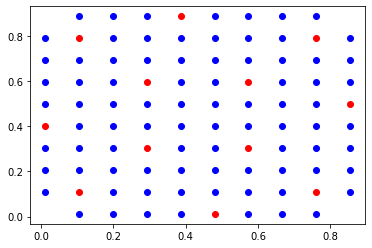

In [9]:
if training_layout == 1:
    tokens = ["x1_y5", "x2_y2", "x2_y9", "x5_y10", "x6_y1", "x9_y2", "x9_y9", "x10_y6"] # Layout 1
elif training_layout == 2:
    tokens = ["x2_y2", "x2_y9", "x4_y4", "x4_y7", "x7_y4", "x7_y7", "x9_y2", "x9_y9"] # Layout 2
elif training_layout == 3:
    tokens = ["x1_y4", "x1_y7", "x4_y1", "x4_y4", "x4_y7", "x4_y10", "x7_y1", "x7_y4", "x7_y7", "x7_y10", "x10_y4", "x10_y7"] # Layout 3
elif training_layout == 4:
    tokens = ["x1_y5", "x2_y2", "x2_y9", "x4_y4", "x4_y7", "x5_y10", "x6_y1", "x7_y4", "x7_y7", "x9_y2", "x9_y9", "x10_y6"] # Arrangement 4
elif training_layout == 5:
    tokens = ["x1_y4", "x2_y2", "x1_y7", "x2_y9", "x4_y1", "x4_y4", "x4_y7", "x4_y10", "x7_y1", "x7_y4", "x7_y7", "x7_y10", "x9_y2", "x9_y9", "x10_y4", "x10_y7"] # Layout 5
elif training_layout == 6:
    tokens = ["x1_y4", "x2_y2", "x1_y7", "x2_y9", "x4_y1", "x5_y7", "x6_y4", "x3_y4", "x3_y7", "x4_y10", "x7_y1", "x8_y4", "x8_y7", "x7_y10", "x9_y2", "x9_y9", "x10_y4", "x10_y7"] # Layout 6


training_group, test_group = create_custom_training_set (srs_path = train_set_path, tokens = tokens, specific = True)

plot_custom_training_set (training_group, test_group)

In [10]:
train_X, train_Y = create_labeled_data(srs_path = train_set_path, label_type = model_type, category_group = training_group)
test_X, test_Y = create_labeled_data(srs_path = test_set_path, label_type = model_type, category_group = test_group)
val_X, val_Y = create_labeled_data(srs_path = validation_set_path, label_type = model_type)

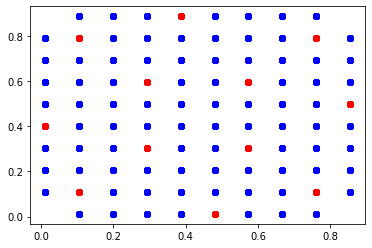

In [11]:
plt.scatter(val_Y[:,0], val_Y[:,1], c='b')
plt.scatter(train_Y[:,0], train_Y[:,1], c='r')
plt.show()

In [47]:
model = CNN_regression(input_shape = (size[1], size[0], channel_sensors))
model.summary()
model.save(model_file_name)

tf.keras.utils.plot_model(model, model_file_name + ".png", show_shapes=True, show_layer_names=True, expand_nested=True)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 8, 16, 60)         2760      
_________________________________________________________________
batch_normalization_12 (Batc (None, 8, 16, 60)         240       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 4, 8, 60)          0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 4, 8, 80)          43280     
_________________________________________________________________
batch_normalization_13 (Batc (None, 4, 8, 80)          320       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 2, 4, 80)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 2, 4, 160)        

In [ ]:
train_model(model_file_name = model_file_name, target_mse = target_mse, accuracy_threshold = accuracy_threshold)

MSE = 0.013640103262867588, mean = 0.09996305976365914, MaxError = 0.4526160809534776
mode = 3302, 0.06; meadian = 2843.0, 0.09244893328680283; mean = 2952.0, 0.09996305976365902.


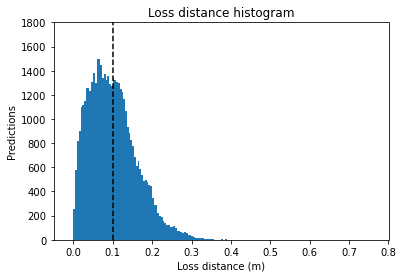

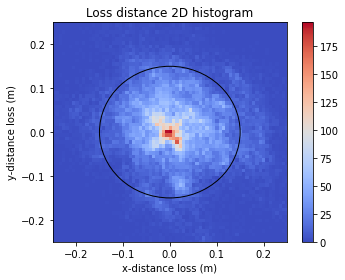

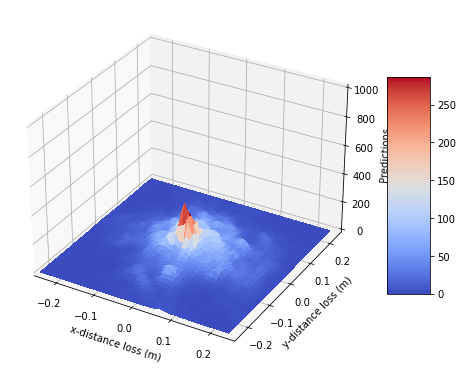

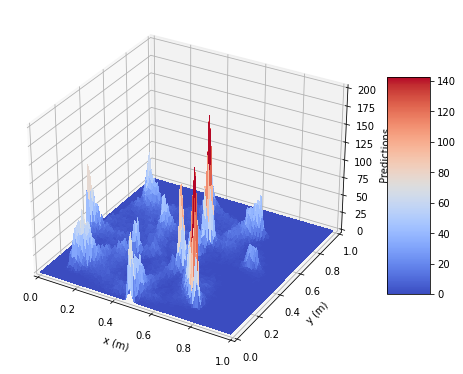

Max MSE = 0.0608631620865539, (0.855,0.795)


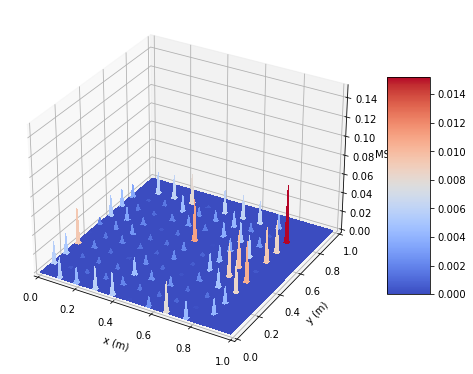

Sensors = 5
MSE = 0.013640103262867588
Ave error = 0.09996305976365914 m
Max error = 0.4526160809534776 m
Accuracy = 0.8072916666666666
Mode = 3302, 0.06


In [49]:
model = load_model(model_file_name)

model_evaluation = evaluate_regression(model = model, val_X = val_X, val_Y = val_Y, accuracy_threshold = accuracy_threshold, plot_histogram = True, file_name = "float32")

print("Sensors = {}".format(channel_sensors))
print_model_evaluation (model_evaluation)

In [50]:
model.save("F32_" + model_file_name)

MSE = 0.013640103262867588, mean = 0.09996305976365914, MaxError = 0.4526160809534776
mode = 3302, 0.06; meadian = 2843.0, 0.09244893328680283; mean = 2952.0, 0.09996305976365902.


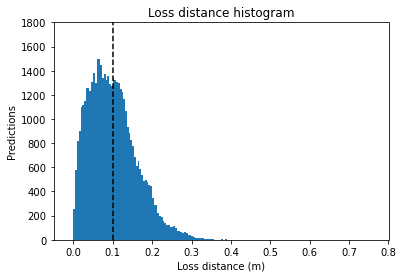

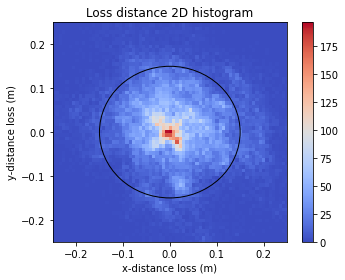

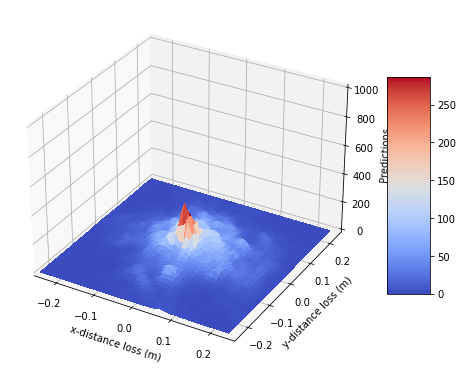

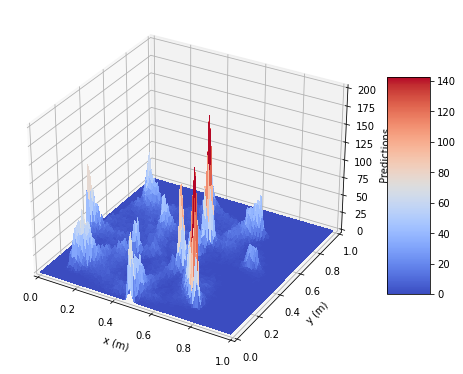

Max MSE = 0.0608631620865539, (0.855,0.795)


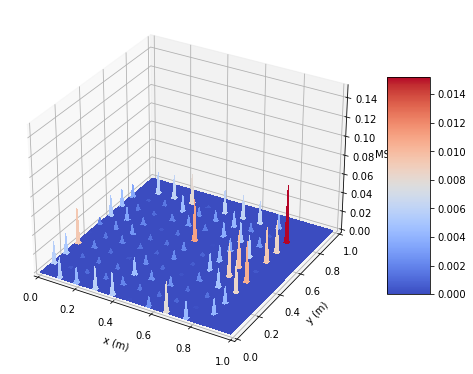

Sensors = 5
MSE = 0.013640103262867588
Ave error = 0.09996305976365914 m
Max error = 0.4526160809534776 m
Accuracy = 0.8072916666666666
Mode = 3302, 0.06


In [51]:
model = load_model("F32_" + model_file_name)

model_evaluation = evaluate_regression(model = model, val_X = val_X, val_Y = val_Y, accuracy_threshold = accuracy_threshold, plot_histogram = True, file_name = "float32")

print("Sensors = {}".format(channel_sensors))
print_model_evaluation (model_evaluation)

In [52]:
convert_to_TF_Lite_float32(model_file_name)

INFO:tensorflow:Assets written to: /tmp/tmprmve1ots/assets


INFO:tensorflow:Assets written to: /tmp/tmprmve1ots/assets
2022-04-01 17:34:24.484126: I tensorflow/core/grappler/devices.cc:78] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2022-04-01 17:34:24.485715: I tensorflow/core/grappler/clusters/single_machine.cc:356] Starting new session
2022-04-01 17:34:24.498499: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:928] Optimization results for grappler item: graph_to_optimize
  function_optimizer: function_optimizer did nothing. time = 0.008ms.
  function_optimizer: function_optimizer did nothing. time = 0.003ms.

2022-04-01 17:34:24.606764: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:316] Ignored output_format.


model_8x16x5.h5 has been converted to TF Lite (float32).


2022-04-01 17:34:24.607078: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:319] Ignored drop_control_dependency.


In [53]:
convert_to_TF_Lite_int8(model_file_name = model_file_name, val_X = val_X)

INFO:tensorflow:Assets written to: /tmp/tmp51d1t6y0/assets


INFO:tensorflow:Assets written to: /tmp/tmp51d1t6y0/assets
2022-04-01 17:34:26.985037: I tensorflow/core/grappler/devices.cc:78] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2022-04-01 17:34:26.985215: I tensorflow/core/grappler/clusters/single_machine.cc:356] Starting new session
2022-04-01 17:34:26.987171: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:928] Optimization results for grappler item: graph_to_optimize
  function_optimizer: function_optimizer did nothing. time = 0.002ms.
  function_optimizer: function_optimizer did nothing. time = 0ms.

2022-04-01 17:34:27.070390: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:316] Ignored output_format.
2022-04-01 17:34:27.070431: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:319] Ignored drop_control_dependency.


model_8x16x5.h5 has been converted to TF Lite (int8).


mode = 3136, 0.05; meadian = 2950.0, 0.09380463428883729; mean = 3049.0, 0.10078135276406397.


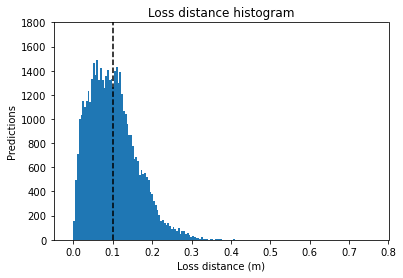

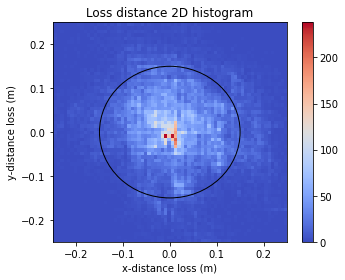

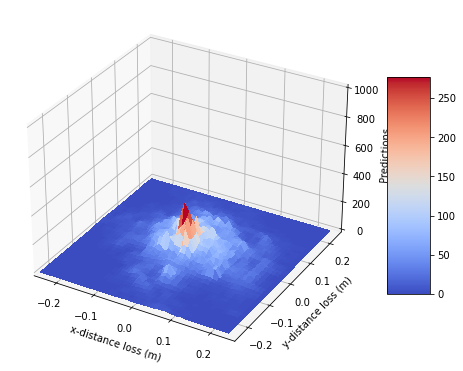

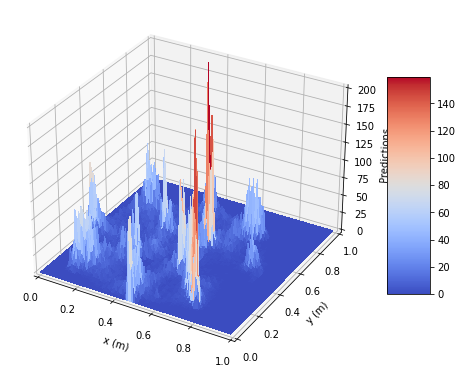

Max MSE = 0.06104266244140625, (0.855,0.795)


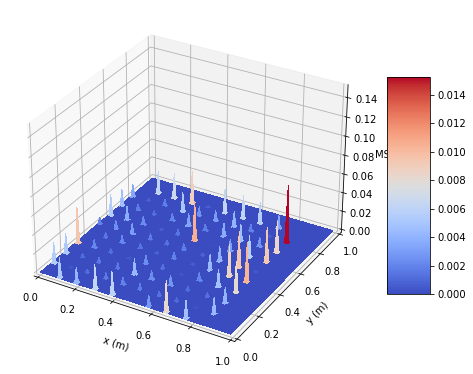

Sensors = 5
MSE = 0.013766288600463866
Ave error = 0.100781352764063 m
Max error = 0.463183398856827 m
Accuracy = 0.8041875
Mode = 3136, 0.05


In [54]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path = model_file_name + "_i8" + '.tflite')
interpreter.allocate_tensors()

model_evaluation = evaluate_regression_TF_Lite(interpreter = interpreter, val_X = val_X, val_Y = val_Y, accuracy_threshold = accuracy_threshold, plot_histogram = True, file_name="int8")

print("Sensors = {}".format(channel_sensors))
print_model_evaluation (model_evaluation)

In [ ]:
exponent_bit_width = 4
mantissa_bit_width = 1

quantize_enable = True

tune_metric = 1 # 1="MSE", 2="AVE ERROR", 3="FIXED MODE", 4="LOWER MODE", 5="ACCURACY"
max_mode = 3450 #3250
lowest_mse = 0.020
lowest_mean = 0.007
format_name = "E" + str(exponent_bit_width) + "M" + str(mantissa_bit_width)

tuning_schedule = { "Refine 1" : (False, 1000),
                    "Refine 2" : (False, 500 ),
                    "Refine 3" : (False, 100 ),
                    #"Capture 1" : (True,  1000),
                    #"Capture 2" : (True,  100 ),
                    #"Capture 3" : (True,  100 ),
                    #"Capture 2" : (True,  50 ),
                    "Capture 3" : (True,  10 )
                  }

plot_histogram = True

tuning_parameters = {
    "base_model_file_name" : "F32_" + model_file_name,
    "model_file_name" : format_name + "_" + model_file_name,
    "tune" : tune_metric,
    "max_mode" : max_mode,
    "lowest_mse" : lowest_mse,
    "lowest_mean" : lowest_mean,
    "exponent_bit_width" : exponent_bit_width,
    "mantissa_bit_width" : mantissa_bit_width,
    "train_set_x" : train_X,
    "train_set_y" : train_Y,
    "test_set_x" : test_X,
    "test_set_y" : test_Y,
    "val_set_x" : val_X,
    "val_set_y" : val_Y,
    "accuracy_threshold" : accuracy_threshold,
    "tuning_epochs" : 1,
    "tuning_schedule" : tuning_schedule,
    "quantize_enable" : quantize_enable,
    "plot_histogram" : plot_histogram
    }

custom_floating_point_tuning(tuning_parameters)

In [83]:
quantize_model(model, exponent_bit_width, mantissa_bit_width)

MSE = 0.012370374920697716, mean = 0.09520837313079515, MaxError = 0.4740989844803363
mode = 3670, 0.07; meadian = 3445.0, 0.08674837163255078; mean = 2917.0, 0.0952083731307951.


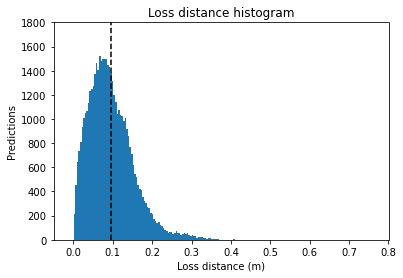

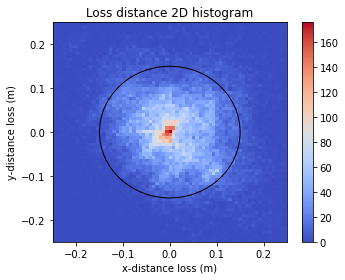

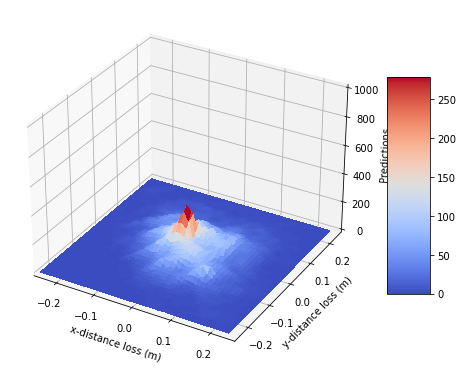

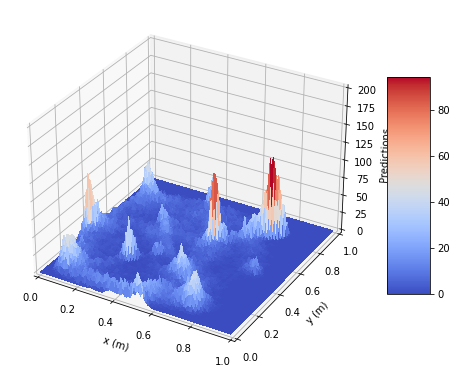

Max MSE = 0.06083804501065979, (0.475,0.595)


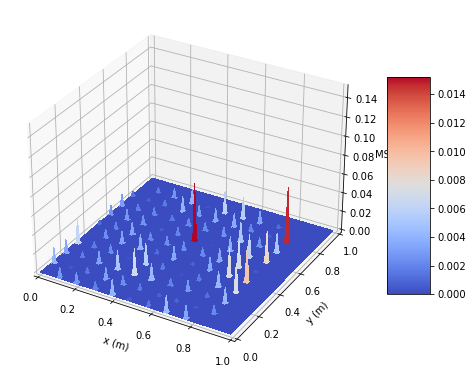

Sensors = 5
MSE = 0.012370374920697716
Ave error = 0.09520837313079515 m
Max error = 0.4740989844803363 m
Accuracy = 0.850375
Mode = 3670, 0.07


In [56]:
model = load_model(format_name + "_" + model_file_name)

#print_model (model)

model_evaluation = evaluate_regression(model = model, val_X = val_X, val_Y = val_Y, accuracy_threshold = accuracy_threshold, plot_histogram = True, file_name=format_name)

print("Sensors = {}".format(channel_sensors))
print_model_evaluation (model_evaluation)

In [57]:
convert_to_TF_Lite_int8(model_file_name = format_name + "_" + model_file_name, val_X = val_X)

INFO:tensorflow:Assets written to: /tmp/tmpyt_j2mrz/assets


INFO:tensorflow:Assets written to: /tmp/tmpyt_j2mrz/assets
2022-04-01 17:59:57.953148: I tensorflow/core/grappler/devices.cc:78] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2022-04-01 17:59:57.953407: I tensorflow/core/grappler/clusters/single_machine.cc:356] Starting new session
2022-04-01 17:59:57.962436: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:928] Optimization results for grappler item: graph_to_optimize
  function_optimizer: function_optimizer did nothing. time = 0.005ms.
  function_optimizer: function_optimizer did nothing. time = 0.001ms.



E4M1_model_8x16x5.h5 has been converted to TF Lite (int8).


2022-04-01 17:59:58.060120: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:316] Ignored output_format.
2022-04-01 17:59:58.060152: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:319] Ignored drop_control_dependency.


mode = 3711, 0.08; meadian = 3506.0, 0.08744599337769855; mean = 2944.0, 0.09631743761800127.


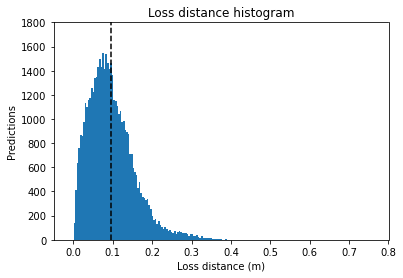

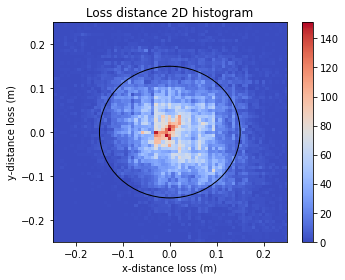

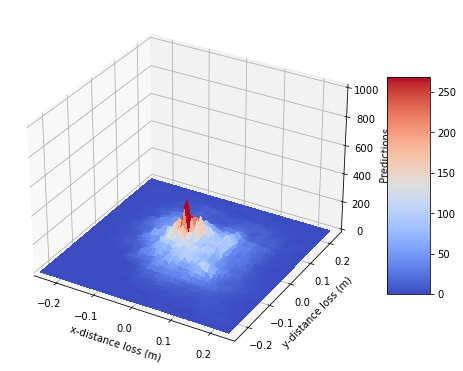

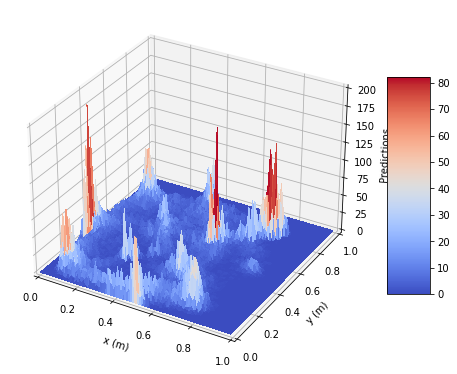

Max MSE = 0.06457394541992187, (0.475,0.595)


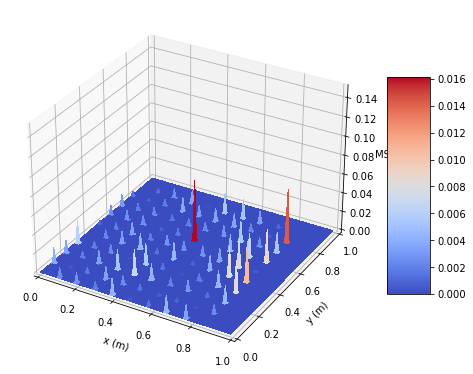

Sensors = 5
MSE = 0.01269796303334554
Ave error = 0.0963174376180008 m
Max error = 0.46163218397469863 m
Accuracy = 0.843875
Mode = 3711, 0.08


In [58]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path = format_name + "_" + model_file_name + "_i8" + '.tflite')
interpreter.allocate_tensors()

model_evaluation = evaluate_regression_TF_Lite(interpreter = interpreter, val_X = val_X, val_Y = val_Y, accuracy_threshold = accuracy_threshold, plot_histogram = True, file_name="int8(E4M0)")

print("Sensors = {}".format(channel_sensors))
print_model_evaluation (model_evaluation)

Input sample = validation_set/P_x8_y5/sample_2251.npy, model prediction = [[0.6438177  0.32065073]]
(0.6665, 0.4012)


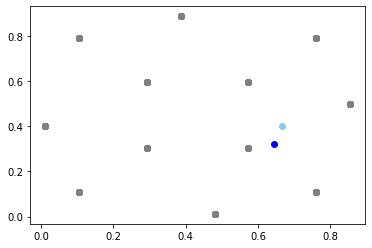

In [59]:
category_name = "P_x8_y5"

file = validation_set_path + "/" + category_name + "/sample_2251.npy"

sample = np.load(file)
sample = sample.astype('float32') / 255.0
sample = np.expand_dims(sample, axis=0)

model = load_model(model_file_name)

model_output = model.predict(sample)

if model_type == "regression":
    print("Input sample = {}, model prediction = {}".format(file, model_output))
else:
    print("Input sample = {}, model prediction = {}".format(file, get_category(model_output)))

tensor = np.zeros((1, 2))

x_i = int(category_name.split("_")[1].split("x")[1]) - 1
y_i = int(category_name.split("_")[2].split("y")[1]) - 1

x_pos = 0.0935 * x_i + 0.012
y_pos = 0.0973 * y_i + 0.012
tensor[0,:] = [x_pos, y_pos]

print("({}, {})".format(x_pos, y_pos))

plt.scatter(train_Y[:,0], train_Y[:,1], c='gray')
plt.scatter(tensor[:,0], tensor[:,1], c='skyblue')
plt.scatter(model_output[:,0], model_output[:,1], c='blue')
plt.show()

Grid (sample = 280, channels = 3)


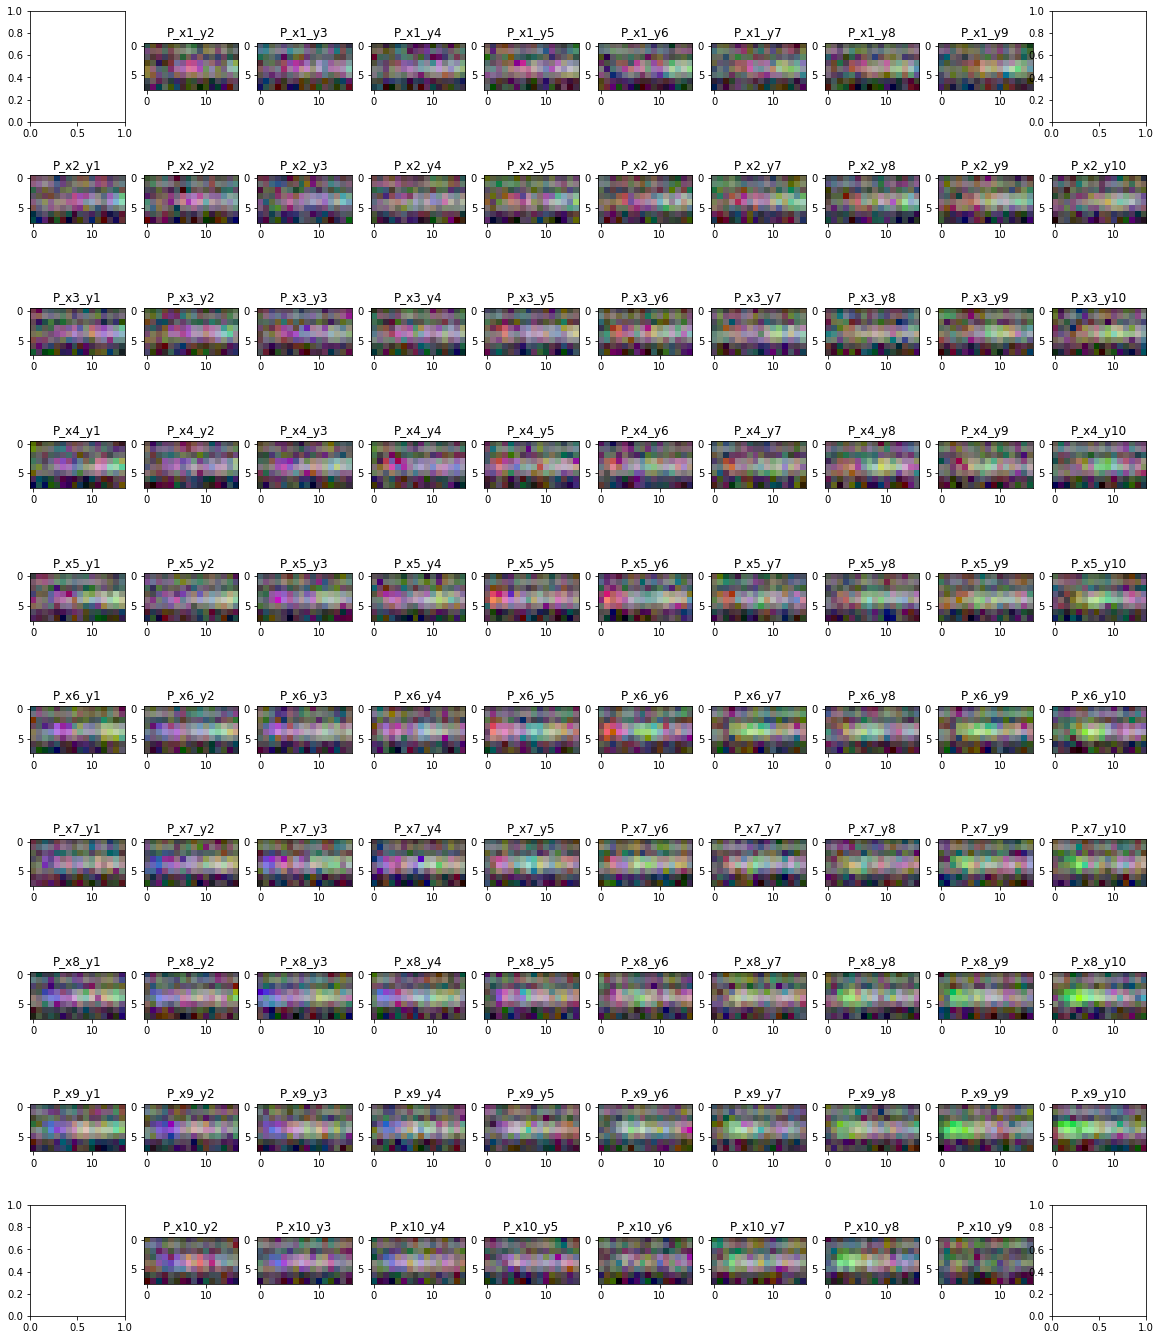

In [ ]:
show_grid(sample = 280, channels = 3, crop_area = crop_area, size = size)

Sample = 280, class = P_x10_y9


/tmp/ipykernel_138036/1394040217.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


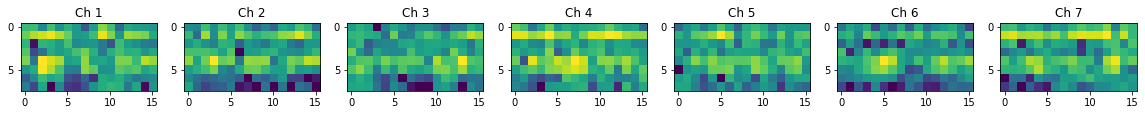

In [ ]:
show_sample(class_name = "P_x10_y9", sample = 280, crop_area = crop_area, size = size)

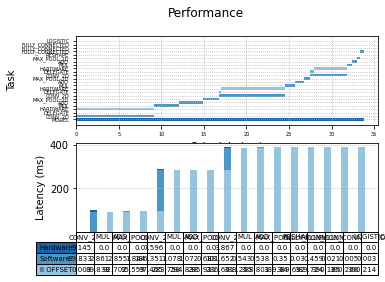

In [1]:
import matplotlib.pyplot as plt
import numpy as np

fig, (ax1, ax2) = plt.subplots(2, 1)

fig.suptitle('Performance')

#Python:
begin   = np.array([0.000, 0.002, 0.005, 0.032, 9.201, 12.065, 14.922, 16.765, 16.768, 16.959, 24.567, 25.646, 26.719, 27.413, 27.415, 27.976, 31.851, 32.396, 32.935, 33.287, 33.318, 33.778, 33.799, 33.806, ])
latency = np.array([33.810, 9.196, 0.033, 9.145, 2.862, 2.855, 1.842, 7.799, 0.213, 7.596, 1.077, 1.071, 0.692, 4.436, 0.571, 3.867, 0.543, 0.538, 0.350, 0.030, 0.458, 0.020, 0.005, 0.003, ])
event   = ["MODEL", "CONV_2D", "DELEGATE", "HARDWARE", "MUL", "ADD", "MAX_POOL_2D", "CONV_2D", "DELEGATE", "HARDWARE", "MUL", "ADD", "MAX_POOL_2D", "CONV_2D", "DELEGATE", "HARDWARE", "MUL", "ADD", "MAX_POOL_2D", "RESHAPE", "FULLY_CONNECTED", "FULLY_CONNECTED", "FULLY_CONNECTED", "LOGISTIC", ]
colors  = ["#1864ab", "#4a98c9", "#6faed4", "#94c4df", "#4a98c9", "#4a98c9", "#4a98c9", "#4a98c9", "#6faed4", "#94c4df", "#4a98c9", "#4a98c9", "#4a98c9", "#4a98c9", "#6faed4", "#94c4df", "#4a98c9", "#4a98c9", "#4a98c9", "#4a98c9", "#4a98c9", "#4a98c9", "#4a98c9", "#4a98c9", ]

data = [[0.003, 89.838, 92.702, 95.559, 97.405, 283.758, 284.838, 285.911, 286.601, 388.255, 388.801, 389.340, 389.692, 389.724, 390.185, 390.208, 390.214, ],
        [ 89.833, 2.861, 2.855, 1.844, 186.351, 1.078, 1.072, 0.688, 101.652, 0.543, 0.538, 0.350, 0.030, 0.459, 0.021, 0.005, 0.003, ],
        [ 9.145, 0.000, 0.000, 0.000, 7.596, 0.000, 0.000, 0.000, 3.867, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, ]]
columns = ("CONV_2D", "MUL", "ADD", "MAX_POOL_2D", "CONV_2D", "MUL", "ADD", "MAX_POOL_2D", "CONV_2D", "MUL", "ADD", "MAX_POOL_2D", "RESHAPE", "FULLY_CONNECTED", "FULLY_CONNECTED", "FULLY_CONNECTED", "LOGISTIC", )


ax1.barh(range(len(begin)),  latency, left=begin, color=colors)
ax1.grid(linestyle = ':')


plt.sca(ax1)
plt.yticks(range(len(begin)), event)
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.tick_params(axis='both', which='minor', labelsize=1)

plt.xlabel("Schedule (ms)")
plt.ylabel("Task")

rows = ["Hardware", "Software", "II OFFSET"]

# Get some pastel shades for the colors
colors = plt.cm.Blues(np.linspace(0.4, 0.8, len(rows)))
n_rows = len(data)

index = np.arange(len(columns)) + 0.3
bar_width = 0.4

# Initialize the vertical-offset for the stacked bar chart.
y_offset = np.zeros(len(columns))

# Plot bars and create text labels for the table
cell_text = []
for row in range(n_rows):
    ax2.bar(index, data[row], bar_width, bottom=y_offset, color=colors[row])
    y_offset = y_offset + data[row]
    cell_text.append(data[row])
# Reverse colors and text labels to display the last value at the top.
colors = colors[::-1]
cell_text.reverse()

plt.sca(ax2)
# Add a table at the bottom of the axes
the_table = ax2.table(cellText=cell_text,
                      rowLabels=rows,
                      rowColours=colors,
                      colLabels=columns,
                      loc='bottom',
                      fontsize='xx-small')

the_table.auto_set_font_size(False)
the_table.set_fontsize(7)


# Adjust layout to make room for the table:

plt.subplots_adjust(left=0.2, bottom=0.2)

plt.ylabel("Latency (ms)")

plt.xticks([])
ax2.grid(linestyle = ':')


plt.show()